# Chapter 4: Testing and regularization with Turi Create

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
random.seed(0)

## Defining our dataset

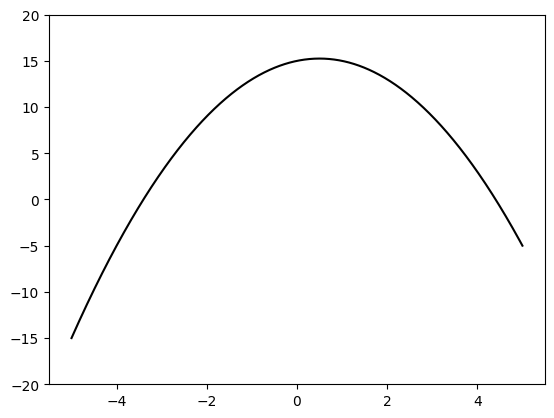

In [2]:
# Our original polynomial is -x^2+x+15
coefs = [15,1,-1]

def polynomial(coefs, x):
    n = len(coefs)
    return sum([coefs[i]*x**i for i in range(n)])

def draw_polynomial(coefs):
    n = len(coefs)
    x = np.linspace(-5, 5, 1000)
    plt.ylim(-20,20)
    plt.plot(x, sum([coefs[i]*x**i for i in range(n)]), linestyle='-', color='black')

draw_polynomial(coefs)

In [3]:
X = []
Y = []
for i in range(50):
    x = random.uniform(-5,5)
    
    
    y = polynomial(coefs, x) + random.gauss(0,2)
    X.append(x)
    Y.append(y)

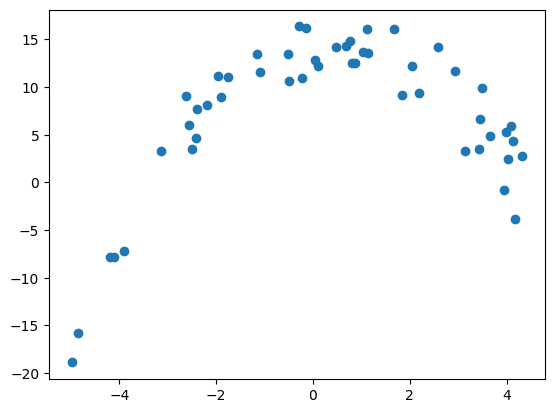

In [4]:
plt.scatter(X, Y)
#draw_polynomial(coefs)

## Training a polynomial regression model

In [5]:
import turicreate as tc

In [6]:
data = tc.SFrame({'x':X, 'y':Y})
data 

x,y
3.4442185152504816,6.685961311021467
-2.4108324970703663,4.690236225597948
0.11274721368608542,12.205789026637378
-1.9668727392107255,11.133217991032268
-0.23403045847644144,10.927272159051856
0.046868558173902564,12.8584762866286
-2.1816215560029617,8.16012255928749
-2.4949365863755943,3.5061587527226514
4.097462559682402,5.933186396721837
4.021659504395828,2.454299054753137


### Adding columns to our dataset corresponding to $x^2, x^3, \ldots, x^{200}$

In [7]:
features = ['x']
for i in range(2,200):
    string = 'x^'+str(i)
    features.append(string)
    #data[string] = data['x'].apply(lambda x:x**i)
    data[string] = data['x']**i
#data
data.print_rows(num_rows=10, num_columns=20)

+----------------------+--------------------+----------------------+
|          x           |         y          |         x^2          |
+----------------------+--------------------+----------------------+
|  3.4442185152504816  | 6.685961311021467  |  11.862641180794233  |
| -2.4108324970703663  | 4.690236225597948  |  5.812113328930538   |
| 0.11274721368608542  | 12.205789026637378 | 0.012711934193975809 |
| -1.9668727392107255  | 11.133217991032268 |  3.8685883722503025  |
| -0.23403045847644144 | 10.927272159051856 | 0.05477025549469338  |
| 0.046868558173902564 |  12.8584762866286  | 0.002196661745300489 |
| -2.1816215560029617  |  8.16012255928749  |  4.759472613616784   |
| -2.4949365863755943  | 3.5061587527226514 |  6.224708570035504   |
|  4.097462559682402   | 5.933186396721837  |  16.789199427999062  |
|  4.021659504395828   | 2.454299054753137  |  16.173745169297295  |
+----------------------+--------------------+----------------------+
+-----------------------+---------

## Splitting data into training and testing

In [8]:
train, test = data.random_split(.8, seed=0)

In [9]:
def display_results(model):
    coefs = model.coefficients
    print("Training error (rmse):", model.evaluate(train)['rmse'])
    print("Testing error (rmse):", model.evaluate(test)['rmse'])
    plt.scatter(train['x'], train['y'], marker='o')
    plt.scatter(test['x'], test['y'], marker='^')
    draw_polynomial(coefs['value'])
    plt.show()
    print("Polynomial coefficients")
    print(coefs['name', 'value'])

## Training a polynomial regression model with no regularization

In [10]:
model_no_reg = tc.linear_regression.create(
    train, target='y', l1_penalty=0.0, l2_penalty=0.0, verbose=False, validation_set=None)

Training error (rmse): 1.3382272325617788
Testing error (rmse): 3.5681242018139385


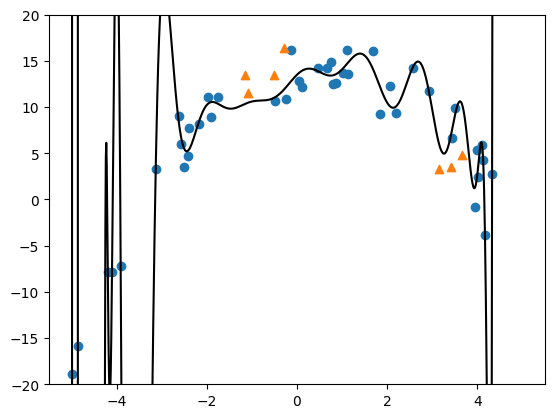

Polynomial coefficients
+-------------+---------------------+
|     name    |        value        |
+-------------+---------------------+
| (intercept) |  13.49996514810482  |
|      x      |  4.723528655855269  |
|     x^2     |  -6.466954485854045 |
|     x^3     | -10.650910302274845 |
|     x^4     |  10.005437499508995 |
|     x^5     |  13.097763858264793 |
|     x^6     |  -6.57458501497761  |
|     x^7     | -7.0581599108315825 |
|     x^8     |  2.2913202732549305 |
|     x^9     |  1.8613276615711896 |
+-------------+---------------------+
[200 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.


In [11]:
display_results(model_no_reg)

In [12]:
degree = [i for i in range(1, 11)]
print(degree)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


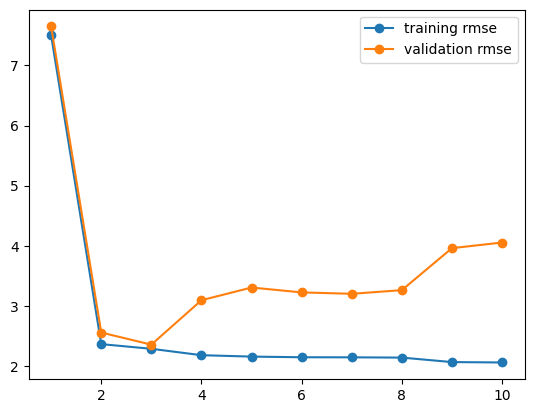

In [13]:
train_error = []
val_error = []
for n in range(1, 11):
    model = tc.linear_regression.create(
        train, target='y', l1_penalty=0.0, l2_penalty=0.0, verbose=False,
        validation_set=None, features = features[0:n])
    train_error.append(model.evaluate(train)['rmse'])
    val_error.append(model.evaluate(test)['rmse'])
    
plt.plot(degree, train_error, marker='o')
plt.plot(degree, val_error, marker='o')
plt.legend(['training rmse', 'validation rmse'])
plt.show()

## Training a polynomial regression model with L1 regularization

In [14]:
#model_L1_reg = tc.linear_regression.create(train, target='y', l1_penalty=0.1, l2_penalty=0.0, verbose=False, validation_set=None, features = features)
model_L1_reg = tc.linear_regression.create(
    train, target='y', l1_penalty=0.1, l2_penalty=0.0, verbose=False, validation_set=None)

Training error (rmse): 9.3779204367541
Testing error (rmse): 10.080162123989725


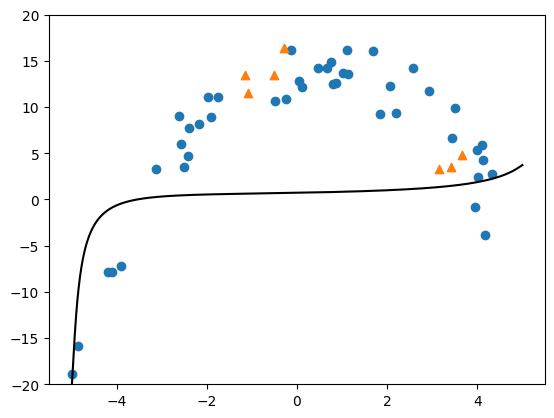

Polynomial coefficients
+-------------+-------------------------+
|     name    |          value          |
+-------------+-------------------------+
| (intercept) |    0.7237925811235593   |
|      x      |   0.09118542912855321   |
|     x^2     |   0.01235706554478867   |
|     x^3     |   0.004654502140516865  |
|     x^4     |  -0.0001072539058774367 |
|     x^5     |  0.00021760544685171123 |
|     x^6     | -1.7944532747701476e-05 |
|     x^7     |  9.013165900085544e-06  |
|     x^8     |  -1.006636474326979e-06 |
|     x^9     |  3.467991864256406e-07  |
+-------------+-------------------------+
[200 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.


In [15]:
display_results(model_L1_reg)

## Training a polynomial regression model with L2 regularization

In [16]:
model_L2_reg = tc.linear_regression.create(
    train, target='y', l1_penalty=0.0, l2_penalty=0.1, verbose=False, validation_set=None)

Training error (rmse): 2.103771083491511
Testing error (rmse): 3.384351022334563


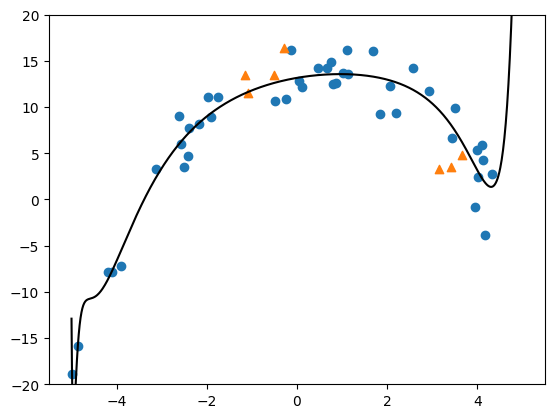

Polynomial coefficients
+-------------+-------------------------+
|     name    |          value          |
+-------------+-------------------------+
| (intercept) |    13.162465256037832   |
|      x      |    0.8428535825881448   |
|     x^2     |   -0.45488038686564636  |
|     x^3     |   0.03695280260279846   |
|     x^4     |  -0.019506339435388913  |
|     x^5     |  0.0004901125603828779  |
|     x^6     |  -0.0007049896336173938 |
|     x^7     |  -4.209536341256629e-05 |
|     x^8     | -1.6124629597753195e-05 |
|     x^9     | -2.2774247599719505e-06 |
+-------------+-------------------------+
[200 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.


In [17]:
display_results(model_L2_reg)

## Viewing the predictions in the testing set

In [18]:
predictions = test['x', 'y']
predictions['No reg'] = model_no_reg.predict(test)
predictions['L1 reg'] = model_L1_reg.predict(test)
predictions['L2 reg'] = model_L2_reg.predict(test)

In [19]:
predictions

x,y,No reg,L1 reg,L2 reg
-0.2785728454728664,16.36505651355184,11.948707346309956,0.6992480981423739,12.891451664732527
3.6530992777164,4.83366913200435,10.402692262432538,1.6129197287600443,6.268997372171768
-0.5203042856442961,13.47860807272069,10.974703395608088,0.6790214503340304,12.594114398228687
3.14466863291336,3.2664703661537313,6.119208624382736,1.3436400523380332,9.697061424742556
-1.1509885402733957,13.436894195835206,10.34840067851179,0.6274141062843831,11.49659894966965
3.424602231401824,3.5269925176080537,7.194530977751128,1.4780916731652867,8.015593834295
-1.087039497653751,11.572117170027912,10.47433354948011,0.6327648062020981,11.632177542991746
